# Predictors of fan voting for the NBA All-Star Game, 1975 - Present

We've scraped the following data from basketball-reference.com:

1. Per-100 possession data for all NBA players from 1974-present (per-100 stats have only been calaculated from 1974 onward)
2. Fan voting for the all-star roster from 1975-present (basketball-reference only has all-star voting from 1975 onward)

There have been different narratives through history surrounding what makes a "good" basketball player in a given era. Every sport has eras, in which certain styles and players are popular, and while coaches and general managers are supposed to objective, fans have no such obligation. Here, we're going to look back through the last 30 years of NBA basketball, and try to figure out how fans' opinions of who the best players in the NBA are has evolved with the sport.

In [1]:
# Import a couple of standard packages
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# And set the path to the directory with our data
path = '/Users/rjp34/Desktop/NBA/Data/'

I've chosen to use player season statistics per-100 posessions, as this allows us to examine a player's individual contributions to a team corrected for slower or faster styles of play. For example, we cannot necessarily compare two players point totals without understanding how many points their team scores in a given game (is scoring 20 out of 80 total points better or worse than scoring 30 out of 120 total points?).

Let's take a look at which data are available for a given player in a given year:

In [2]:
p100_1975 = pd.read_csv(path + 'nba_1974_per_poss.csv')
display(p100_1975.head())
col_include = [ii for ii in p100_1975.columns if ii != 'Unnamed: 0' and ii != 'Rk' and ii != 'Pos' and ii != 'Tm']

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
0,0,1,Zaid Abdul-Aziz,C,27,HOU,79,NaN,2459,6.2,...,12.2,17.0,3.1,1.5,1.9,NaN,4.2,15.9,NaN,96
1,1,2,Kareem Abdul-Jabbar*,C,26,MIL,81,NaN,3548,12.2,...,11.4,15.1,5.0,1.4,3.6,NaN,3.1,28.1,NaN,89
2,2,3,Don Adams,SF,26,DET,74,NaN,2298,5.9,...,6.2,8.8,2.8,2.2,0.2,NaN,4.7,14.9,NaN,94
3,3,4,Rick Adelman,PG,27,CHI,55,NaN,618,4.7,...,3.9,5.1,4.1,2.7,0.1,NaN,4.7,13.5,NaN,94
4,4,5,Lucius Allen,PG,26,MIL,72,NaN,2388,10.0,...,3.9,5.6,7.1,2.6,0.4,NaN,4.1,24.2,NaN,95


Initially, we're going to disregard team (Tm) and position (Pos). We're interested in individual contributions, and while I can totally see the potential for a team's record impacting fan voting, we're going to limit ourselves to individual contributions for now. Positions are voted on separately, and the expectation for what a given position does has changed significantly throughout the history of the NBA. It could be interesting to re-do this analysis at a later date and see how fans vote on a given position, but for now we are going to combine all positions to increase our sample size.

Also, in the interest of honesty it is worth noting that the stats used here are averaged over an entire NBA season, while All-Star voting occurs at the mid-season mark. It is *possible* that a player might have gotten significantly better or worse after the All-Star voting occurred, resulting in per-100 stats that are not reflective of the performances that got them votes, but for now we will operate under the assumption that player performance is relatively inertial: top perfomers continued to perform well.

We want to predict vote share for each year, so this is a regression problem. With the number of predictors, it will be most appropriate to use a random forest.

In [3]:
allstar_voting = pd.read_csv(path + 'nba_allstar_voting.csv')
t_year = []
for year in range(1975, 2019):
    
    # There was no All-Star Game in 1999 because of the NBA lockout
    if year != 1999:
        t_year.append(year)

        # Pull out a dataframe with the vote totals for All-Stars in the selected year
        df_y = allstar_voting.loc[allstar_voting.Year == year, ['Player', 'Votes']]
        df_y.reset_index(drop = True, inplace = True)

        # And read in the per-100 possession stats for the same year
        df_x = pd.read_csv(path + 'nba_' + str(year) + '_per_poss.csv')
        
        # Some players switched teams during a season. It would be best to do a weighted average of different
        # statistics, but we're going to take a simpler approach, based on a couple pieces of domain knowledge:
        # 1. This isn't baseball. Most really good NBA players (All-Stars) aren't traded during the season. So 
        # the intersect of all stars and players who were traded mid-season is likely small
        # 2. Players that are traded are generally traded past mid-season, so if we just take the first value for 
        # seasons in which they played for multiple teams, we are probably still getting a pretty good
        # representation of how they played
        df_x.drop_duplicates(subset = 'Player', keep = 'first', inplace = True)
        df_x.reset_index(drop = True, inplace = True)
          
        # Fill in missing values with 0. We only have missing values when a player has no data for a given column.
        # This can happen when a player has never shot a 3-point field goal for example, or when a given statistic
        # was not tracked (for example, 3-point field goals were not tracked until the 3-point line was 
        # introduced).
        df_x.fillna(0, inplace = True)
        
        # Basketball-reference marks Hall-of-FamePrs with asterisks on the per-possesion stats page, but not on the
        # All-Star voting page. We have to remove the asterisks to eventually join the DataFrames
        for ii, name in enumerate(df_x.Player):
            if '*' in name:
                df_x.loc[ii, 'Player'] = name.replace('*', '')

        # We don't really care about totals, we care about how good a given player is compared to their peers.
        # That is, we shouldn't be concerned about points per 100 possesions, we should care about where a player
        # ranks in points per 100 possesions relative to the rest of the NBA that year
        df_x_pct = df_x[col_include].rank(pct = True)
        df_x_pct['Player'] = df_x['Player']

        # Now we need to join the two, so we have the percentile for each per-100 statistic for players receiving
        # All-Star votes
        df_full = pd.merge(df_y, df_x_pct, left_on = 'Player', right_on = 'Player', how = 'left')
        
        # Some players received votes without playing during a season. We will drop them
        df_full.dropna(axis = 0, how = 'any', inplace = True)

        # Pull out features we are actually interested in using
        X = df_full.drop(['Player', 'Votes', 'G', 'GS', 'MP', '3P%', 'FG%', '2P%', 'FT%'], axis = 1)
        if year == 1975:
            col = X.columns
        X = X.values
        
        # And vote totals (our output)
        y = df_full['Votes'].values

        # And now we build a forest of 100 trees from 
        regr = RFR(n_estimators = 100, oob_score = True)
        regr.fit(X, y)
        
        # We write the predicted feature importance to a DataFrame
        if year == 1975:
            feature_importance = pd.DataFrame(columns = col)
            oob_score = []
            r2_train = []
            winner = pd.DataFrame(columns = ['Year', 'Name', 'Votes received', 'Votes predicted', 'FG', '3P', 'PTS', 'AST',
                                             'TRB', 'STL', 'BLK'])
            loser = winner
        f_i = regr.feature_importances_
        feature_importance = feature_importance.append(pd.DataFrame(f_i.reshape(-1, len(f_i)), columns = col),
                                                       ignore_index = True)
        
        # Output the out of bag score, and the r-squared value on the training data for each year to see how the model performed
        oob_score.append(regr.oob_score_)
        r2_train.append(r2_score(regr.predict(X), y))
        
        # We want to see where voters were inconsistent in a given year. Who received more votes than the data would indicate,
        # and who received fewer votes than the data would indicate
        df_full = pd.merge(df_x_pct, df_y, left_on = 'Player', right_on = 'Player', how = 'left')
        df_full = df_full.fillna(0)
        X_test = df_full[col]
        X_test = X_test.values
        y_test = df_full['Votes']
        y_pred = regr.predict(X_test)
        
        # Maximum and minimum differences between the predicted and received votes
        y_diff = y_pred - y_test
        l_idx = np.argmax(y_diff)
        w_idx = np.argmin(y_diff)
          
        w_ = pd.DataFrame(data = np.reshape([year, df_x.loc[w_idx, 'Player'], y_test[w_idx], y_pred[w_idx],
                                             df_x.loc[w_idx, 'FG'], df_x.loc[w_idx, '3P'], df_x.loc[w_idx, 'PTS'],
                                             df_x.loc[w_idx, 'AST'], df_x.loc[w_idx, 'TRB'], df_x.loc[w_idx, 'STL'],
                                             df_x.loc[w_idx, 'BLK']], (1, 11)), columns = winner.columns)
        l_ = pd.DataFrame(data = np.reshape([year, df_x.loc[l_idx, 'Player'], y_test[l_idx], y_pred[l_idx],
                                             df_x.loc[l_idx, 'FG'], df_x.loc[l_idx, '3P'], df_x.loc[l_idx, 'PTS'],
                                             df_x.loc[l_idx, 'AST'], df_x.loc[l_idx, 'TRB'], df_x.loc[l_idx, 'STL'],
                                             df_x.loc[l_idx, 'BLK']], (1, 11)), columns = winner.columns)
        winner = winner.append(w_, ignore_index = True)
        loser = loser.append(l_, ignore_index = True)

**Winners**

In [4]:
display(winner)

,Year,Name,Votes received,Votes predicted,FG,3P,PTS,AST,TRB,STL,BLK
0,1975,John Havlicek,87715.0,63528.09,9.3,0.0,22.7,6.2,7.0,1.6,0.2
1,1976,John Havlicek,135273.0,104716.19,8.7,0.0,22.3,4.8,5.4,1.7,0.5
2,1977,David Thompson,319047.0,264728.89,11.8,0.0,30.6,4.8,4.8,1.6,0.8
3,1978,Julius Erving,396503.0,323461.0,11.1,0.0,27.9,5.1,8.8,2.5,1.8
4,1979,George Gervin,427540.0,346431.71,14.2,0.0,35.6,3.3,6.0,2.1,1.4
5,1980,George Gervin,286463.0,233388.87,15.3,0.5,38.6,3.0,6.0,1.6,1.2
6,1981,Julius Erving,304600.0,262094.67,12.8,0.1,32.5,5.9,10.6,2.8,2.4
7,1982,Julius Erving,432230.0,374191.76,13.3,0.1,33.8,5.5,9.5,2.8,2.4
8,1983,Moses Malone,687741.0,547595.74,10.5,0.0,30.5,1.6,19.1,1.4,2.5
9,1984,Moses Malone,927779.0,707081.6,9.8,0.0,29.7,1.8,17.5,1.3,2.0


**Losers**

In [5]:
display(loser)

,Year,Name,Votes received,Votes predicted,FG,3P,PTS,AST,TRB,STL,BLK
0,1975,Ken Boyd,0.0,55402.82,12.3,0.0,33.3,3.5,8.8,5.3,0.0
1,1976,Jerry Sloan,0.0,100348.86,6.5,0.0,17.3,1.7,9.0,2.1,0.4
2,1977,Bubbles Hawkins,0.0,233156.2,12.7,0.0,31.4,2.9,4.8,2.4,0.8
3,1978,Fred Brown,0.0,259320.43,11.8,0.0,27.8,5.6,4.4,2.6,0.6
4,1979,John Drew,0.0,268809.86,12.6,0.0,34.9,2.3,10.1,2.5,0.3
5,1980,Billy Ray Bates,0.0,189949.56,14.9,1.7,37.3,6.4,6.0,2.9,0.4
6,1981,Robert Parish,0.0,247699.7,13.2,0.0,32.2,3.0,16.1,1.7,4.4
7,1982,John McCullough,0.0,303206.13,18.9,0.0,44.0,6.3,8.4,4.2,0.0
8,1983,Bobby Jones,0.0,442821.19,6.7,0.0,17.8,3.8,9.2,2.3,2.4
9,1984,Darrell Walker,0.0,610730.74,7.9,0.1,23.6,10.4,6.1,4.6,0.5


Looking over the last 40 years of all-star voting, we can definitely get some insight into how fans are voting. Superstars seem to be getting a disproportionately large number of votes, relative to where their stats are pushing our model. Moving forward, it might be interesting to look at stickiness in All-Star voting: that is, see if the nunber of years a player has been in the All-Star game results in additional votes. A couple historical oddities stand out as well: in Kobe Bryant's final season (2016), he received over 700,000 more votes than the 2016 random forest model would have expected. Similarly, a mass voting campaign in Zaza Pachulia's home country of Georgia likely lead to his anomalously high 2017 vote total.

Looking at the losers, we can see that our model is not nearly sensitive enough to how much a player actually playes. Apparently, Dahntay Jones "should have" received far more votes than he did in 2017, despite only playing in 1 game that season. Similarly, we can see an issue with the data we have fed the model: Jeremy Lin's series of breakout performances in 2012 were indeed picked up by the random forest, but all of those came after All-Star voting had occurred. At the time of voting, he had not done anything to justify his inclusion.

Let's look at how important different statistics are for predicting fan voting for the All-Star Game. Earlier, we pulled out the importance of each feature for each year's model.

In [6]:
pd.DataFrame(feature_importance.mean())

,0
Age,0.034100
FG,0.090305
FGA,0.051736
3P,0.010750
3PA,0.019648
2P,0.062089
2PA,0.039843
FT,0.060833
FTA,0.107616
ORB,0.023448


There's mostly noise here. The main takeaway is that over time, no one performance statistic has had a runaway importance with determining how many votes fans give a player. Total points, free-throw attempts, and total field goals appear to matter the most, but these are likely highly correlated. Let's take a look at the importance of a couple of these over time.

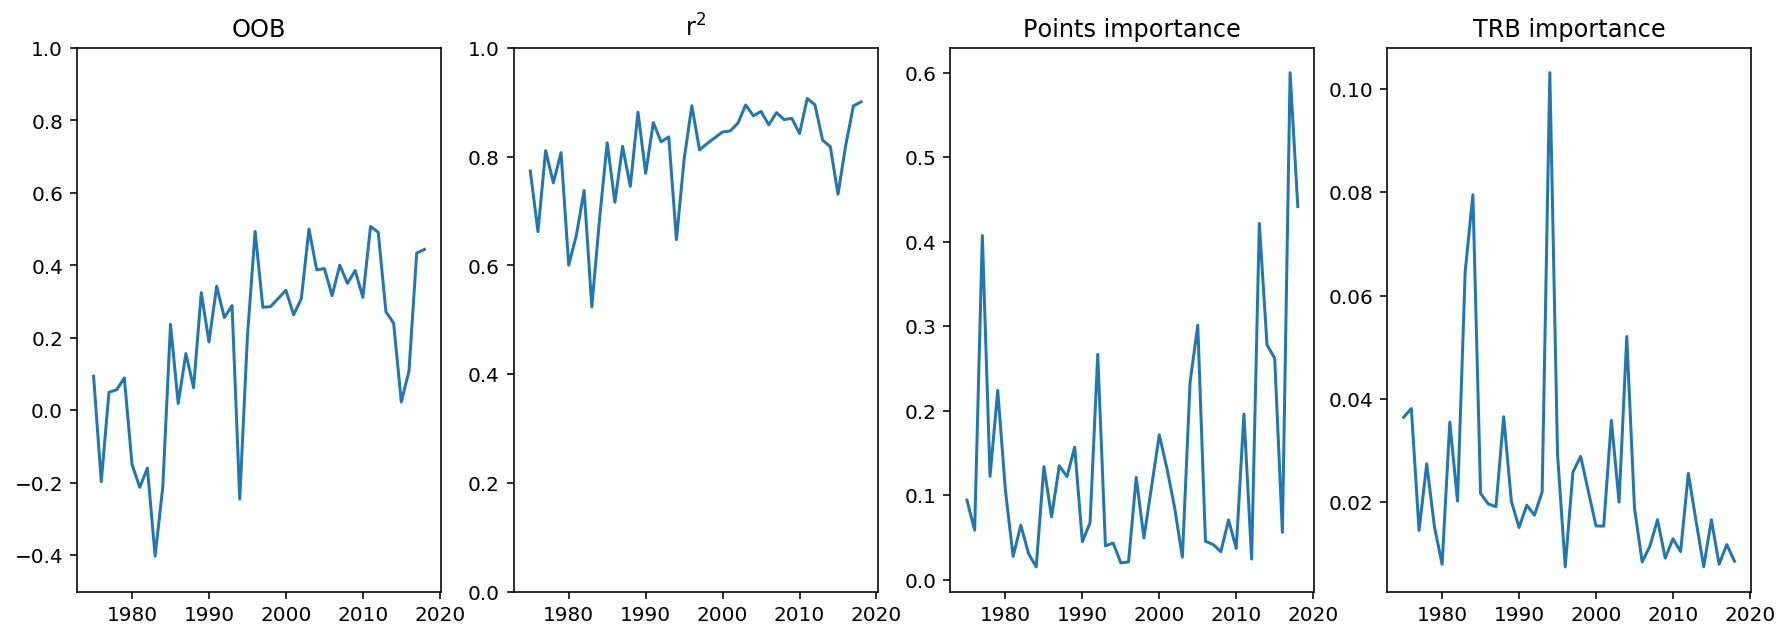

In [7]:
fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(nrows = 1, ncols = 4)

ax_1.plot(t_year, oob_score)
ax_1.set_title('OOB')
ax_1.set_ylim(-.5, 1)

ax_2.plot(t_year, r2_train)
ax_2.set_title('r$^2$')
ax_2.set_ylim(0, 1)

ax_3.plot(t_year, feature_importance['PTS'].values)
ax_3.set_title('Points importance')

ax_4.plot(t_year, feature_importance["TRB"].values)
ax_4.set_title('TRB importance')


fig.set_figheight(5)
fig.set_figwidth(15)
plt.show()

These are pretty terrible out of bag scores. An OOB less than 0 means that the random forest really can't model the input data, and we can see this in our r$^2$ values for the training data. We can never get an r$^2$ over 0.9 on the data being used to ***build the model***. Looking at how feature importance in total points and total rebounds have mattered to voters over time, we see more evidence that the models are just unable to make any sense out of the data being fed to them. Interannual variability is extremely large in both cases, indicating that over time, voting is driven more by individual preferences in a given year, rather than any sort of longer-term, coherent trends.

***

So what have we learned from this? Not much, apart from the fact that despite the richness of historical NBA data, fan vote share doesn't really behave in a predictable manner. Sure, we could remove data, and start correcting for the market size they play in, star power, and remove joke votes (the Zaza Pachulia factor), but then we're removing the fan vote itself.